In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import os
from scipy.stats import ranksums
from statsmodels.formula.api import mixedlm
from tkinter import filedialog
import tkinter as tk

In [2]:
# Glabal variables

# Constants
PIXEL_TO_CM = 40 / 480  # Conversion factor from pixels to cm
FRAME_RATE = 30         # Frames per second
VIDEO_LENGTH = 30 * 60     # Video length in seconds
BIN_DURATION = 5 * 60   # Bin duration in seconds (5 minutes)

# Set plot font size
plt.rcParams.update({'font.size': 18})

In [3]:
# functions
# -------------------- Data Loading Functions --------------------

def load_deeplabcut_data(file_path):
    """Load and preprocess DeepLabCut data from a CSV file."""
    try:
        deeplabcut_data = pd.read_csv(file_path)
        deeplabcut_cleaned = deeplabcut_data.iloc[2:].copy()
        deeplabcut_cleaned.columns = ['frame', 'x', 'y', 'likelihood']
        deeplabcut_cleaned = deeplabcut_cleaned[['frame', 'x', 'y', 'likelihood']].astype(float)
        deeplabcut_cleaned['frame'] = deeplabcut_cleaned['frame'].astype(int)
        return deeplabcut_cleaned
    except Exception as e:
        print(f"Error loading DeepLabCut file {file_path}: {e}")
        return None


def load_boris_data(file_path):
    """Load and preprocess BORIS behavior data from a CSV file."""
    try:
        with open(file_path, 'r') as f:
            boris_lines = f.readlines()

        behavior_header = "Time,Media file path,Total length,FPS,Subject,Behavior,Behavioral category,Comment,Status\n"
        start_line = boris_lines.index(behavior_header) + 1

        boris_behavior_full_data = pd.read_csv(file_path, skiprows=start_line, header=None)
        boris_behavior_cleaned = boris_behavior_full_data[[0, 5]].copy()
        boris_behavior_cleaned.columns = ['time', 'behavior']
        boris_behavior_cleaned['time'] = pd.to_numeric(boris_behavior_cleaned['time'], errors='coerce')
        boris_behavior_cleaned = boris_behavior_cleaned.dropna()
        return boris_behavior_cleaned
    except Exception as e:
        print(f"Error loading BORIS file {file_path}: {e}")
        return None


# -------------------- Data Processing Functions --------------------

def smooth_deeplabcut_data(data, sigma=1):
    """Apply Gaussian smoothing to the x and y coordinates."""
    data['x_smooth'] = gaussian_filter1d(data['x'], sigma=sigma)
    data['y_smooth'] = gaussian_filter1d(data['y'], sigma=sigma)
    return data


def calculate_displacement(data, pixel_to_cm):
    """Calculate displacement between consecutive frames."""
    data['dx'] = data['x_smooth'].diff().fillna(0)
    data['dy'] = data['y_smooth'].diff().fillna(0)
    data['displacement'] = np.sqrt(data['dx']**2 + data['dy']**2) * pixel_to_cm
    return data


def bin_displacement_data(data, bin_duration, frame_rate):
    """Bin displacement data by time intervals."""
    data['time'] = data['frame'] / frame_rate
    data['time_bin'] = (data['time'] // bin_duration).astype(int)
    displacement_binned = data.groupby('time_bin')['displacement'].sum().reset_index()
    displacement_binned.columns = ['time_bin', 'total_displacement']
    return displacement_binned

def fill_missing_time_bins(data, total_bins):
    """
    Fills missing time bins in the given DataFrame with zeros for all behavior columns.
    
    Parameters:
    - data (pd.DataFrame): The input DataFrame containing `time_bin` and behavior columns.
    - total_bins (int): The total number of bins expected (e.g., maximum time_bin + 1).
    
    Returns:
    - pd.DataFrame: The DataFrame with missing time bins filled with zeros.
    """
    # 確保 time_bin 是索引，並重設完整索引
    all_bins = pd.DataFrame({'time_bin': range(total_bins)})  # 建立完整的 time_bin 範圍
    data = pd.merge(all_bins, data, on="time_bin", how="left")  # 將數據與完整範圍合併
    data.fillna(0, inplace=True)  # 將缺失值填充為 0
    
    return data



def bin_behavior_data(data, bin_duration):
    """Bin BORIS behavior data by time intervals."""

    data['time_bin'] = (data['time'] // bin_duration).astype(int)
    data_filled = fill_missing_time_bins(data, VIDEO_LENGTH // BIN_DURATION)
    behavior_binned = data_filled.groupby(['time_bin', 'behavior']).size().unstack(fill_value=0).reset_index()
    return behavior_binned


def normalize_behavior_by_displacement(behavior_binned, displacement_binned):
    """Normalize behavior counts by displacement for each bin."""
    # 合併行為數據和位移數據
    merged = pd.merge(behavior_binned, displacement_binned, on='time_bin', how='inner')

    # 明確指定要處理的行為列
    behavior_columns = ['L_fl', 'L_hl', 'R_fl', 'R_hl']

    # 檢查指定列是否在數據中
    for col in behavior_columns:
        if col not in merged.columns:
            raise KeyError(f"Expected column '{col}' not found in data.")
    
    # 正規化行為數據
    normalized_behavior = merged.copy()
    for behavior in behavior_columns:
        normalized_behavior[behavior] = np.where(
            merged['total_displacement'] > 0,
            merged[behavior] * 100 / merged['total_displacement'],  # 正規化公式
            0  # 如果位移為 0，行為事件設為 0
        )

    # 丟棄不需要的列，例如 total_displacement
    normalized_behavior = normalized_behavior[['time_bin'] + behavior_columns]

    return normalized_behavior



def group_mean_and_sem(data_list):
    """Calculate group mean and SEM for a list of normalized dataframes."""
    # 合併所有小鼠的資料
    combined_data = pd.concat(data_list, axis=0)
    
    # 過濾出數字類型的行為列（排除非數字列如 'group' 和 'mouse_id'）
    numeric_columns = combined_data.select_dtypes(include=['number'])
    
    # 計算分組的平均值和標準誤
    group_mean = numeric_columns.groupby('time_bin').mean()
    group_sem = numeric_columns.groupby('time_bin').sem()
    
    return group_mean, group_sem


def process_group(dlc_files, boris_files, pixel_to_cm, bin_duration, frame_rate, group_name, output_dir):
    """Process data for a specific group."""
    processed_data = []

    for dlc_file, boris_file in zip(dlc_files, boris_files):
        mouse_id = os.path.basename(dlc_file).split('_')[0]  # Extract the Mouse ID from filename
        print(f"Processing files for {group_name}: {os.path.basename(dlc_file)} and {os.path.basename(boris_file)}")

        # Process DeepLabCut file
        displacement_data = load_deeplabcut_data(dlc_file)
        if displacement_data is None:
            continue
        displacement_data = smooth_deeplabcut_data(displacement_data)
        displacement_data = calculate_displacement(displacement_data, pixel_to_cm)
        displacement_binned = bin_displacement_data(displacement_data, bin_duration, frame_rate)

        # Process BORIS file
        behavior_data = load_boris_data(boris_file)
        if behavior_data is None:
            continue
        behavior_binned = bin_behavior_data(behavior_data, bin_duration)

        # Save raw binned data with mouse ID in the filename
        behavior_file = os.path.join(output_dir, f"{group_name}_{mouse_id}_behavior_binned.csv")
        displacement_file = os.path.join(output_dir, f"{group_name}_{mouse_id}_displacement_binned.csv")

        behavior_binned.to_csv(behavior_file, index=False)
        displacement_binned.to_csv(displacement_file, index=False)
        print(f"Saved behavior data to {behavior_file}")
        print(f"Saved displacement data to {displacement_file}")

        # Normalize behavior by displacement
        normalized_behavior = normalize_behavior_by_displacement(behavior_binned, displacement_binned)
        normalized_behavior['group'] = group_name  # Add group label
        normalized_behavior['mouse_id'] = os.path.basename(dlc_file).split('_')[0]  # Extract mouse ID from filename
        processed_data.append(normalized_behavior)

    return processed_data

def prepare_glmm_data(control_data, experiment_data):
    """Prepare combined data for GLMM analysis."""
    # 合併控制組和實驗組資料
    try:
        # 確保 control_data 和 experiment_data 是列表，並且每個元素是 DataFrame
        if not isinstance(control_data, list) or not isinstance(experiment_data, list):
            raise TypeError("Control and experiment data must be lists of DataFrames.")
        if not all(isinstance(df, pd.DataFrame) for df in control_data + experiment_data):
            raise TypeError("All elements in control_data and experiment_data must be DataFrames.")
        
        # 合併所有資料
        combined_data = pd.concat(control_data + experiment_data, axis=0, ignore_index=True)

        # 確保行為列存在
        behavior_columns = ['L_fl', 'L_hl', 'R_fl', 'R_hl']
        missing_columns = [col for col in behavior_columns if col not in combined_data.columns]
        if missing_columns:
            raise ValueError(f"Missing behavior columns in combined data: {missing_columns}")
        
        # 計算行為總數（將所有行為欄位相加）
        combined_data['total_behavior'] = combined_data[behavior_columns].sum(axis=1)

        # 確保必要的 GLMM 欄位存在
        required_columns = ['group', 'time_bin', 'mouse_id']
        missing_required_columns = [col for col in required_columns if col not in combined_data.columns]
        if missing_required_columns:
            raise ValueError(f"Missing required columns for GLMM analysis: {missing_required_columns}")

        # 確保 'group' 和 'time_bin' 是分類數據
        combined_data['group'] = combined_data['group'].astype('category')
        combined_data['time_bin'] = combined_data['time_bin'].astype('category')

        return combined_data
    except Exception as e:
        print(f"Error preparing GLMM data: {e}")
        return None




# -------------------- Statistical Functions --------------------

def perform_glmm(data, output_file):
    """Perform Generalized Linear Mixed Model (GLMM) analysis."""
    try:
        # GLMM model formula
        formula = "total_behavior ~ group * time_bin - 1"
        model = mixedlm(formula, data, groups=data["mouse_id"])
        result = model.fit()

        # Save GLMM results to a file
        with open(output_file, 'w') as f:
            f.write(result.summary().as_text())

        print(f"GLMM results saved to {output_file}")
    except Exception as e:
        print(f"Error performing GLMM analysis: {e}")


# -------------------- Plotting Functions --------------------

def plot_behavior(control_mean, control_sem, experiment_mean, experiment_sem, behaviors, output_dir, bin_duration):
    """Plot group data for control and experiment groups."""
    # 將時間 bin 轉換為分鐘
    time_bins = control_mean.index * bin_duration / 60 + bin_duration / 60 / 2  # 將 bin 轉換為分鐘

    if "Travel Distance" in behaviors:
        # 繪製Travel Distance plot
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            time_bins,
            control_mean["total_displacement"],
            yerr=control_sem["total_displacement"],
            label="Control",
            capsize=5,
            marker='o',
            color='black',
            linestyle='-',
            linewidth=2
        )
        plt.errorbar(
            time_bins,
            experiment_mean["total_displacement"],
            yerr=experiment_sem["total_displacement"],
            label="PV-Cre-LMO3$^{f/f}$",
            capsize=5,
            marker='o',
            color='orange',
            linestyle='-',
            linewidth=2
        )

        # 添加圖表標題和軸標籤
        plt.xlabel("Time (minutes)")
        plt.ylabel("Travel Distance (cm)")
        plt.xticks(time_bins)  # 設定 x 軸標籤為分鐘
        plt.legend()
        plt.grid()

        # 保存圖表
        output_file = os.path.join(output_dir, "Travel Distance_plot.png")
        plt.savefig(output_file)
        print(f"Saved combined plot: {output_file}")
        plt.show()

    else:
        for behavior in behaviors:
            plt.figure(figsize=(10, 6))
            
            # 繪製控制組數據
            plt.errorbar(
                time_bins,
                control_mean[behavior],
                yerr=control_sem[behavior],
                label="Control",
                color='black',
                marker='o',
                capsize=5,
                linewidth=2
            )
            
            # 繪製實驗組數據
            plt.errorbar(
                time_bins,
                experiment_mean[behavior],
                yerr=experiment_sem[behavior],
                label="PV-Cre-LMO3$^{f/f}$",
                color='orange',
                marker='o',
                capsize=5,
                linewidth=2
            )

            # 獲取行為名稱
            if behavior == 'R_fl':
                behavior_name = 'Right Forelimb'
            elif behavior == 'L_fl':
                behavior_name = 'Left Forelimb'
            elif behavior == 'R_hl':
                behavior_name = 'Right Hindlimb'
            elif behavior == 'L_hl':
                behavior_name = 'Left Hindlimb'
            else:
                behavior_name = behavior  # 如果沒有定義名稱，使用原始名稱

            # 圖表標題和軸標籤
            plt.title(behavior_name)
            plt.xlabel("Time (minutes)")
            plt.ylabel("Normalized Foot Faults per Meter")
            plt.xticks(time_bins)  # 設定 x 軸標籤為分鐘
            plt.legend()
            plt.grid()
            
            # 保存圖表
            output_file = os.path.join(output_dir, f"{behavior}_plot.png")
            plt.savefig(output_file)
            print(f"Saved plot: {output_file}")
            plt.show()

        # 計算所有行為的總數
        control_total = control_mean[behaviors].sum(axis=1)
        experiment_total = experiment_mean[behaviors].sum(axis=1)
        control_total_sem = control_sem[behaviors].sum(axis=1)
        experiment_total_sem = experiment_sem[behaviors].sum(axis=1)

        # 繪製所有行為總數的圖表
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            time_bins,
            control_total,
            yerr=control_total_sem,
            label="Control",
            capsize=5,
            marker='o',
            color='black',
            linestyle='-',
            linewidth=2
        )
        plt.errorbar(
            time_bins,
            experiment_total,
            yerr=experiment_total_sem,
            label="PV-Cre-LMO3$^{f/f}$",
            capsize=5,
            marker='o',
            color='orange',
            linestyle='-',
            linewidth=2
        )

        # 添加圖表標題和軸標籤
        plt.title("All Limbs")
        plt.xlabel("Time (minutes)")
        plt.ylabel("Normalized Total Foot Faults per Meter")
        plt.xticks(time_bins)  # 設定 x 軸標籤為分鐘
        plt.legend()
        plt.grid()

        # 保存圖表
        output_file = os.path.join(output_dir, "combined_behavior_plot.png")
        plt.savefig(output_file)
        print(f"Saved combined plot: {output_file}")
        plt.show()



In [4]:
#Select Directory to Save Results

# Initialize file dialog
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw()

# Select output directory
output_dir = filedialog.askdirectory(title="Select Directory to Save Results")
if not output_dir:
    raise ValueError("No output directory selected. Exiting.")

print(f"Output directory selected: {output_dir}")


Output directory selected: D:/works/Data_analysis/projects/grid_walking/2024_09/result


In [5]:
# Select files
print("Processing Control Group")

control_dlc_files = filedialog.askopenfilenames(title="Select Control DeepLabCut CSV Files")
control_boris_files = filedialog.askopenfilenames(title="Select Control BORIS CSV Files")

if len(control_dlc_files) != len(control_boris_files):
    raise ValueError("Mismatch in number of Control DeepLabCut and BORIS files. Exiting.")

print("Processing Experiment Group")

experiment_dlc_files = filedialog.askopenfilenames(title="Select Experiment DeepLabCut CSV Files")
experiment_boris_files = filedialog.askopenfilenames(title="Select Experiment BORIS CSV Files")

if len(experiment_dlc_files) != len(experiment_boris_files):
    raise ValueError("Mismatch in number of Experiment DeepLabCut and BORIS files. Exiting.")

Processing Control Group
Processing Experiment Group


Processing files for Control: 2A_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 2B_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 2E_7_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 3I_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 4F_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 4G_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 6A_10_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 6C_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 6E_7_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv
Processing files for Control: 6G_12_bottomDLC_Resnet50_gridwalking_20240

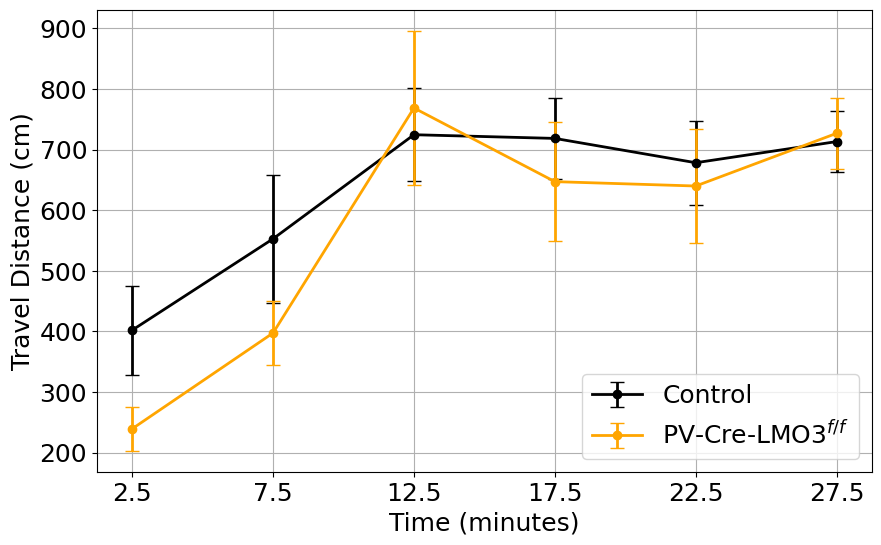

   time_bin  rank_sum_stat   p_value
0         0       1.267731  0.204894
1         1       0.676123  0.498962
2         2      -0.422577  0.672604
3         3       0.845154  0.398025
4         4       0.338062  0.735317
5         5      -0.169031  0.865772
Results saved to'D:/works/Data_analysis/projects/grid_walking/2024_09/result/rank_sum_test_results_td.csv'
GLMM results saved to D:/works/Data_analysis/projects/grid_walking/2024_09/result\glmm_results_td.txt


In [12]:
# Process files (for travel distance)
travel_distance_data_of_control = []
travel_distance_data_of_experiment = []

for dlc_file in control_dlc_files:
    mouse_id = os.path.basename(dlc_file).split('_')[0]  # Extract the Mouse ID from filename
    print(f"Processing files for Control: {os.path.basename(dlc_file)}")

    # Process DeepLabCut file
    displacement_data = load_deeplabcut_data(dlc_file)
    if displacement_data is None:
        continue
    displacement_data = smooth_deeplabcut_data(displacement_data)
    displacement_data = calculate_displacement(displacement_data, PIXEL_TO_CM)
    displacement_binned = bin_displacement_data(displacement_data, BIN_DURATION, FRAME_RATE)
    displacement_binned['group'] = "Control"  # Add group label
    displacement_binned['mouse_id'] = mouse_id  # Extract mouse ID from filename
    travel_distance_data_of_control.append(displacement_binned)

for dlc_file in experiment_dlc_files:
    mouse_id = os.path.basename(dlc_file).split('_')[0]  # Extract the Mouse ID from filename
    print(f"Processing files for Experiment: {os.path.basename(dlc_file)}")

    # Process DeepLabCut file
    displacement_data = load_deeplabcut_data(dlc_file)
    if displacement_data is None:
        continue
    displacement_data = smooth_deeplabcut_data(displacement_data)
    displacement_data = calculate_displacement(displacement_data, PIXEL_TO_CM)
    displacement_binned = bin_displacement_data(displacement_data, BIN_DURATION, FRAME_RATE)
    displacement_binned['group'] = "Experiment"  # Add group label
    displacement_binned['mouse_id'] = mouse_id  # Extract mouse ID from filename
    travel_distance_data_of_experiment.append(displacement_binned)

control_mean_of_travel_distance, control_sem_of_travel_distance = group_mean_and_sem(travel_distance_data_of_control)
experiment_mean_of_travel_distance, experiment_sem_of_travel_distance = group_mean_and_sem(travel_distance_data_of_experiment)

# Plot travel distance data
plot_behavior(control_mean_of_travel_distance, control_sem_of_travel_distance, 
                experiment_mean_of_travel_distance, experiment_sem_of_travel_distance, 
                behaviors="Travel Distance", output_dir=output_dir, bin_duration=BIN_DURATION)

def prepare_glmm_data_td(control_data, experiment_data):
    """Prepare combined data for GLMM analysis."""
    # 合併控制組和實驗組資料
    try:
        # 確保 control_data 和 experiment_data 是列表，並且每個元素是 DataFrame
        if not isinstance(control_data, list) or not isinstance(experiment_data, list):
            raise TypeError("Control and experiment data must be lists of DataFrames.")
        if not all(isinstance(df, pd.DataFrame) for df in control_data + experiment_data):
            raise TypeError("All elements in control_data and experiment_data must be DataFrames.")
        
        # 合併所有資料
        combined_data = pd.concat(control_data + experiment_data, axis=0, ignore_index=True)

        # 確保必要的 GLMM 欄位存在
        required_columns = ['group', 'time_bin', 'mouse_id']
        missing_required_columns = [col for col in required_columns if col not in combined_data.columns]
        if missing_required_columns:
            raise ValueError(f"Missing required columns for GLMM analysis: {missing_required_columns}")

        # 確保 'group' 和 'time_bin' 是分類數據
        combined_data['group'] = combined_data['group'].astype('category')
        combined_data['time_bin'] = combined_data['time_bin'].astype('category')

        return combined_data
    except Exception as e:
        print(f"Error preparing GLMM data: {e}")
        return None

# GLMM analysis (for travel distance)
combined_data_td = prepare_glmm_data_td(travel_distance_data_of_control, travel_distance_data_of_experiment)


# 結果保存列表
results_td = []

# 獲取所有唯一的 time_bin
time_bins = combined_data_td['time_bin'].unique()

# 遍歷每個時間 bin
for bin_ in time_bins:
    # 篩選對應時間 bin 的數據
    data_bin = combined_data_td[combined_data_td['time_bin'] == bin_]
    
    # 分組數據
    control = data_bin[data_bin['group'] == 'Control']['total_displacement']
    experiment = data_bin[data_bin['group'] == 'Experiment']['total_displacement']
    
    # 確保數據存在
    if not control.empty and not experiment.empty:
        # Rank-Sum Test
        stat, p_value = ranksums(control, experiment)
        
        # 保存結果
        results_td.append({
            'time_bin': bin_,
            'rank_sum_stat': stat,
            'p_value': p_value
        })

# 將結果轉為 DataFrame
results_df = pd.DataFrame(results_td)

# 查看結果
print(results_df)

# 將結果保存為 CSV
results_df.to_csv(f'{output_dir}/rank_sum_test_results_td.csv', index=False)
print(f"Results saved to'{output_dir}/rank_sum_test_results_td.csv'")


def perform_glmm_td(data, output_file):
    """Perform Generalized Linear Mixed Model (GLMM) analysis."""
    try:
        # GLMM model formula
        formula = "total_displacement ~ group * time_bin - 1"
        model = mixedlm(formula, data, groups=data["mouse_id"])
        result = model.fit()

        # Save GLMM results to a file
        with open(output_file, 'w') as f:
            f.write(result.summary().as_text())

        print(f"GLMM results saved to {output_file}")
    except Exception as e:
        print(f"Error performing GLMM analysis: {e}")

# Perform GLMM analysis
glmm_file = os.path.join(output_dir, "glmm_results_td.txt")
perform_glmm_td(combined_data_td, glmm_file)

In [6]:
# Process files (for foot fault analysis)
control_data = process_group(
    control_dlc_files, control_boris_files,
    PIXEL_TO_CM, BIN_DURATION, FRAME_RATE,
    "Control", output_dir
)

print(f"Control group processed: {len(control_data)} mice")

experiment_data = process_group(
    experiment_dlc_files, experiment_boris_files,
    PIXEL_TO_CM, BIN_DURATION, FRAME_RATE,
    "Experiment", output_dir
)

print(f"Experiment group processed: {len(experiment_data)} mice")

for i, files in enumerate(control_dlc_files):
    mouse_id = os.path.basename(files).split('_')[0]  # Extract the Mouse ID from filename

    # Save raw binned data with mouse ID in the filename
    control_file = os.path.join(output_dir, f"control_{mouse_id}_behavior_Nor.csv")

    control_data[i].to_csv(control_file, index=False)

for i, files in enumerate(experiment_dlc_files):
    mouse_id = os.path.basename(files).split('_')[0]  # Extract the Mouse ID from filename

    # Save raw binned data with mouse ID in the filename
    experiment_file = os.path.join(output_dir, f"experiment_{mouse_id}_behavior_Nor.csv")

    experiment_data[i].to_csv(experiment_file, index=False)


# Ensure data was loaded successfully
if not control_data or not experiment_data:
    raise ValueError("Data processing failed for one or both groups.")

print("Both control and experiment groups loaded successfully.")


Processing files for Control: 2A_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv and 2A.csv
Saved behavior data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2A_behavior_binned.csv
Saved displacement data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2A_displacement_binned.csv
Processing files for Control: 2B_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv and 2B.csv
Saved behavior data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2B_behavior_binned.csv
Saved displacement data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2B_displacement_binned.csv
Processing files for Control: 2E_7_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv and 2E.csv
Saved behavior data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2E_behavior_binned.csv
Saved displacement data to D:/works/Data_analysis/projects/grid_walking/

In [7]:
# Calculate group means and SEMs
control_mean, control_sem = group_mean_and_sem(control_data)
experiment_mean, experiment_sem = group_mean_and_sem(experiment_data)

print("Group means and SEMs calculated.")


Group means and SEMs calculated.


Saved plot: D:/works/Data_analysis/projects/grid_walking/2024_09/result\L_fl_plot.png


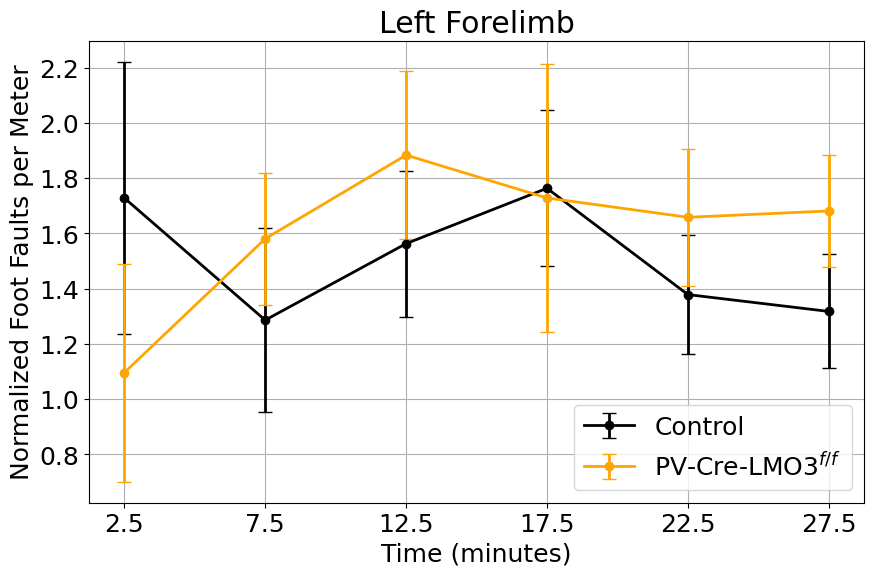

Saved plot: D:/works/Data_analysis/projects/grid_walking/2024_09/result\L_hl_plot.png


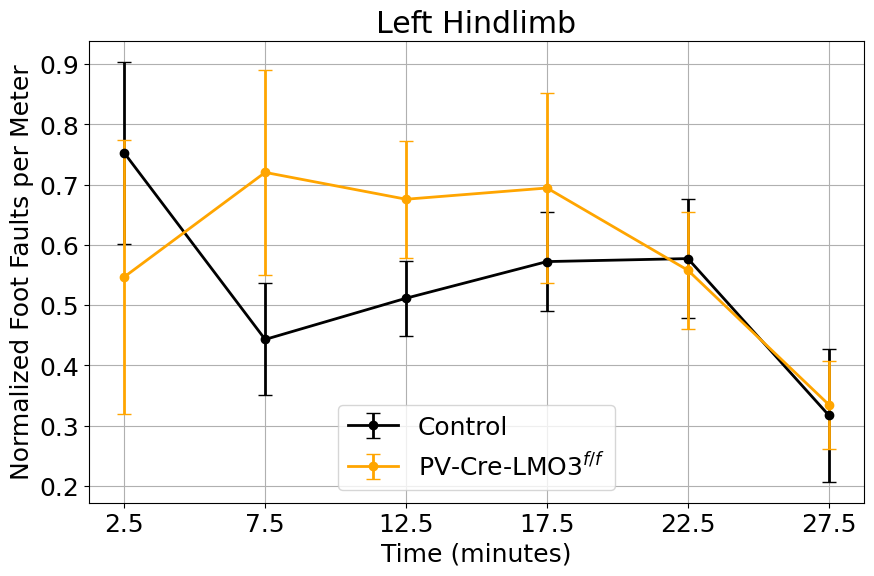

Saved plot: D:/works/Data_analysis/projects/grid_walking/2024_09/result\R_fl_plot.png


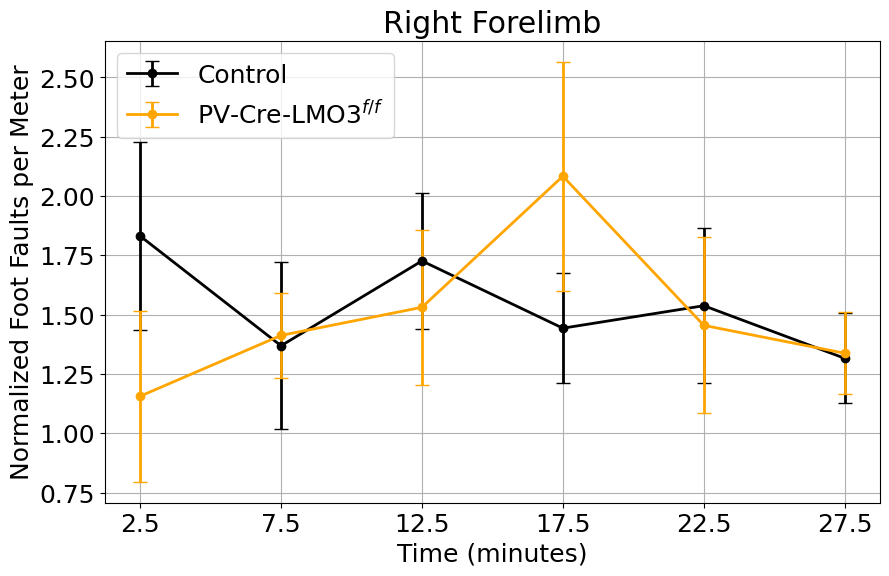

Saved plot: D:/works/Data_analysis/projects/grid_walking/2024_09/result\R_hl_plot.png


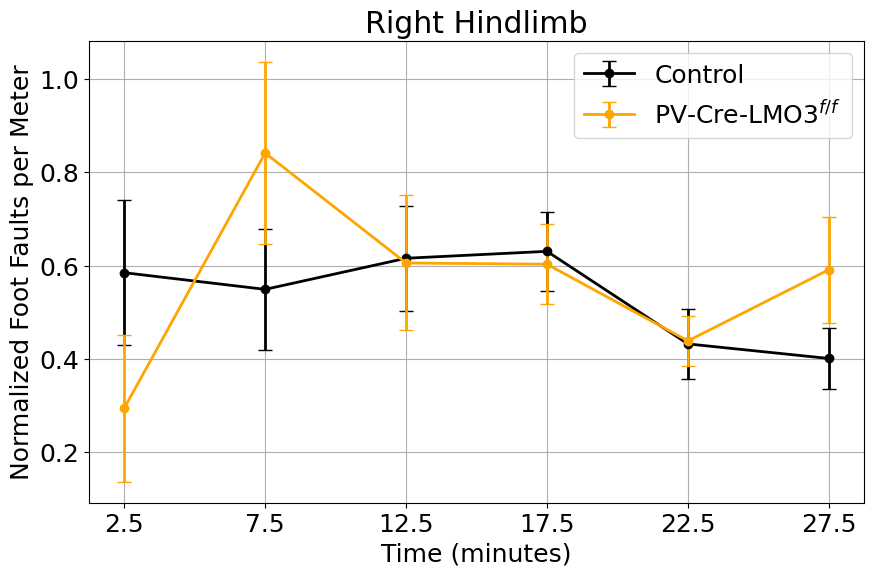

Saved combined plot: D:/works/Data_analysis/projects/grid_walking/2024_09/result\combined_behavior_plot.png


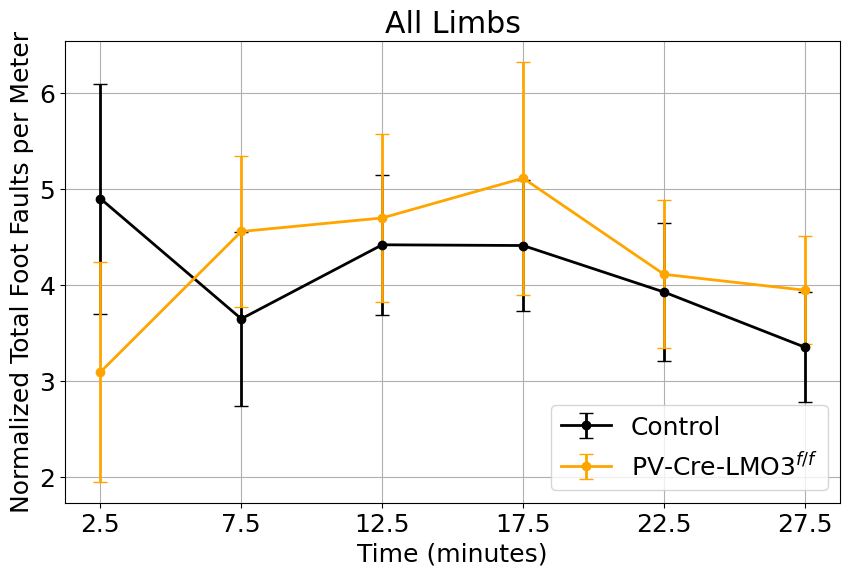

Behavior plots saved.


In [8]:
# Extract all behaviors for plotting
behaviors = control_mean.columns

# Plot and save results
plot_behavior(control_mean, control_sem, experiment_mean, experiment_sem, behaviors, output_dir,BIN_DURATION)

print("Behavior plots saved.")


In [11]:
# Wilcoxon rank-sum test
combined_data = prepare_glmm_data(control_data, experiment_data)

# 結果保存列表
results = []

# 獲取所有唯一的 time_bin
time_bins = combined_data['time_bin'].unique()

# 遍歷每個時間 bin
for bin_ in time_bins:
    # 篩選對應時間 bin 的數據
    data_bin = combined_data[combined_data['time_bin'] == bin_]
    
    # 分組數據
    control = data_bin[data_bin['group'] == 'Control']['total_behavior']
    experiment = data_bin[data_bin['group'] == 'Experiment']['total_behavior']
    
    # 確保數據存在
    if not control.empty and not experiment.empty:
        # Rank-Sum Test
        stat, p_value = ranksums(control, experiment)
        
        # 保存結果
        results.append({
            'time_bin': bin_,
            'rank_sum_stat': stat,
            'p_value': p_value
        })

# 將結果轉為 DataFrame
results_df = pd.DataFrame(results)

# 查看結果
print(results_df)

# 將結果保存為 CSV
results_df.to_csv(f'{output_dir}/rank_sum_test_results.csv', index=False)
print(f"Results saved to'{output_dir}/rank_sum_test_results.csv'")



   time_bin  rank_sum_stat   p_value
0         0       1.140958  0.253887
1         1      -0.676123  0.498962
2         2      -0.338062  0.735317
3         3      -0.169031  0.865772
4         4      -0.507093  0.612090
5         5      -1.183216  0.236724
Results saved to'D:/works/Data_analysis/projects/grid_walking/2024_09/result/rank_sum_test_results.csv'


In [9]:
# GLMM analysis (for foot fault analysis)
combined_data = prepare_glmm_data(control_data, experiment_data)

# Perform GLMM analysis
glmm_file = os.path.join(output_dir, "glmm_results.txt")
perform_glmm(combined_data, glmm_file)


GLMM results saved to D:/works/Data_analysis/projects/grid_walking/2024_09/result\glmm_results.txt
